https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html

Dado que estos métodos de regularización actúan sobre la magnitud de los coeficientes del modelo, todos deben de estár en la misma escala, por esta razón **es necesario estandarizar o normalizar los predictores antes de entrenar el modelo**

**Ridge:** A esta penalización se le conoce como l2 y tiene el efecto de reducir de forma proporcional el valor de todos los coeficientes del modelo pero sin que estos lleguen a cero. hiperparámetro  λ . Cuando  λ=0 no hay penalización. Empleando un valor adecuado de  λ , el método de ridge es capaz de reducir varianza sin apenas aumentar el bias, consiguiendo así un menor error total. La desventaja del método ridge es que, el modelo final, incluye todos los predictores

**Lasso:** A esta penalización se le conoce como l1 y tiene el efecto de forzar a que los coeficientes de los predictores tiendan a cero. Dado que un predictor con coeficiente de regresión cero no influye en el modelo, lasso consigue excluir los predictores menos relevantes. Al igual que en ridge, el grado de penalización está controlado por el hiperparámetro  λ . Cuando  λ=0 , el resultado es equivalente al de un modelo lineal por mínimos cuadrados ordinarios. A medida que  λ  aumenta, mayor es la penalización y más predictores quedan excluidos.

**Elastic net:** incluye una regularización que combina la penalización l1 y l2. El grado en que influye cada una de las penalizaciones está controlado por el hiperparámetro  α . Su valor está comprendido en el intervalo [0,1]. Cuando  α = 0 , se aplica ridge y cuando  α = 1  se aplica lasso. La combinación de ambas penalizaciones suele dar lugar a buenos resultados. Una estrategia frecuentemente utilizada es asignarle casi todo el peso a la penalización l1 (α  muy próximo a 1) para conseguir seleccionar predictores y un poco a la l2 para dar cierta estabilidad en el caso de que algunos predictores estén correlacionados.

**Nota: scikitlearn utiliza el argumento alpha para hacer referencia a lambda y el argumento l1ratio para referirse a alpha**

**Ridge, Lasso y Elastic net, alpha o lambda: (0 - infinito)**

**Elastic net, l1ratio o alpha: (0 - 1)**

# Librerias

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Datos

In [5]:
# Datos
# ==============================================================================
datos = pd.read_csv('data/02_meatspec.csv')
datos = datos.drop(columns = datos.columns[0])
print(datos.info())
datos.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Columns: 101 entries, V1 to fat
dtypes: float64(101)
memory usage: 169.8 KB
None


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4


## Relacion entre variables

In [10]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = datos.select_dtypes(include=['float64', 'int']).corr(method='pearson')
display(tidy_corr_matrix(corr_matrix).head(5))

,variable_1,variable_2,r,abs_r
1019,V11,V10,0.999996,0.999996
919,V10,V11,0.999996,0.999996
1021,V11,V12,0.999996,0.999996
1121,V12,V11,0.999996,0.999996
917,V10,V9,0.999996,0.999996


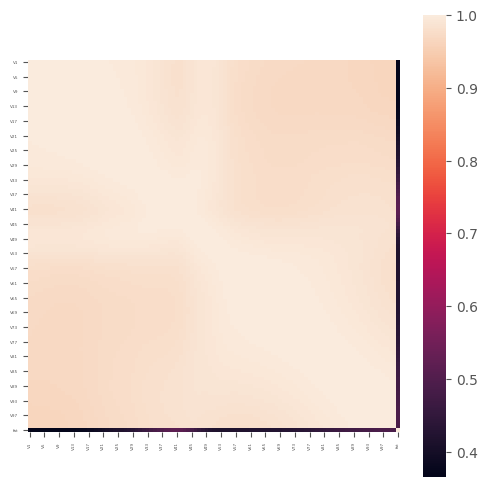

In [13]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.heatmap(
    corr_matrix,
    square    = True,
    ax        = ax
)

ax.tick_params(labelsize = 3)
plt.show();

Muchas de las variables están altamente correlacionadas (correlación absoluta > 0.8), lo que supone un problema a la hora de emplear modelos de regresión lineal.

# Modelos

In [15]:
# División de los datos en train y test
# ==============================================================================
X = datos.drop(columns='fat')
y = datos['fat']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.values.reshape(-1,1),
                                                    train_size   = 0.7,
                                                    random_state = 1234,
                                                    shuffle      = True
                                                    )

## Mínimos cuadrados (OLS)

In [16]:
# Creación y entrenamiento del modelo
# ==============================================================================
modelo = LinearRegression(normalize=True)
modelo.fit(X = X_train, y = y_train)

LinearRegression(normalize=True)

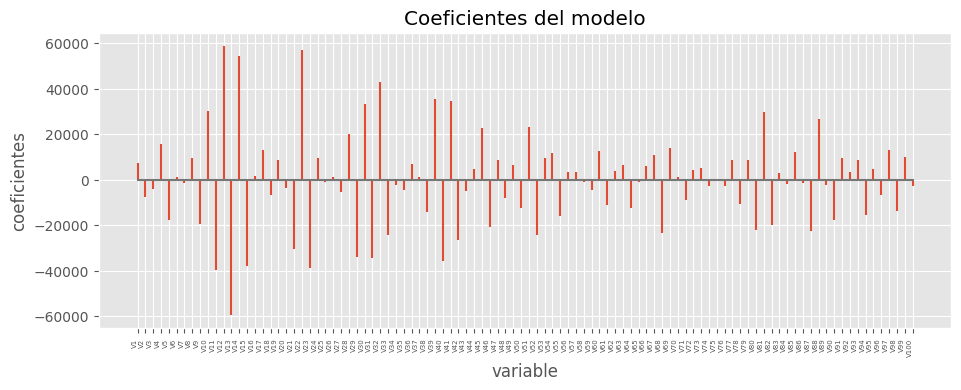

In [23]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                                {'predictor': X_train.columns,
                                 'coef': modelo.coef_.flatten()}
                              )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo')
plt.show();

In [24]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([36.88226752, 62.47992661, 61.04825535,  9.95161352, 18.11993067,
        6.56158193, 28.42860453,  9.18085599, 15.56800749, 16.50461443])

In [25]:
# Error de test del modelo 
# ==============================================================================
rmse_ols = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_ols}")


El error (rmse) de test es: 3.8396675856391465


Las predicciones del modelo final se alejan en promedio 3.84 unidades del valor real.

## Ridge

Cuando se utiliza regularización, es útil evaluar cómo se aproximan a cero los coeficientes a medida que se incrementa el valor de alpha así como la evolución del error de validación cruzada en función del alpha empleado.

In [85]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto RidgeCV utiliza el mean squared error
# np.logspace: base ** start is the starting value of the sequence
modelo = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
         )

_ = modelo.fit(X = X_train, y = y_train)

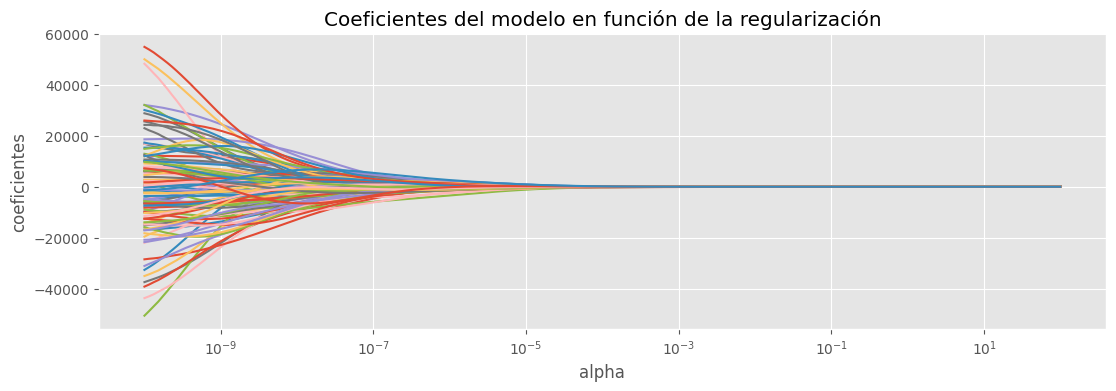

In [86]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(13, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show();

Puede ver se como, a medida que aumenta el valor de alpha, la regularización es mayor y el valor de los coeficientes se reduce.

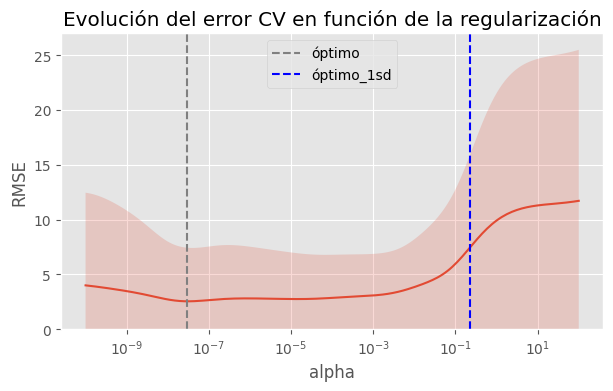

In [87]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_samples, n_targets, n_alphas)
mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)] # np.argmin busca el inidice con el valor rmse_cv
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas, rmse_cv)
ax.fill_between(modelo.alphas, rmse_cv + rmse_sd, rmse_cv - rmse_sd, alpha=0.2)

ax.axvline(x = optimo, c = "gray", linestyle = '--', label = 'óptimo')
ax.axvline(x = optimo_1sd, c = "blue", linestyle = '--', label     = 'óptimo_1sd')

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()
plt.show();

In [88]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 2.9673024081888725e-08


In [90]:
# Mejor valor alpha encontrado + 1sd
# ==============================================================================
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas[rmse_cv == min_rsme_1sd]

print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_1sd}")

Mejor valor de alpha encontrado + 1 desviación estándar: [0.22219469]


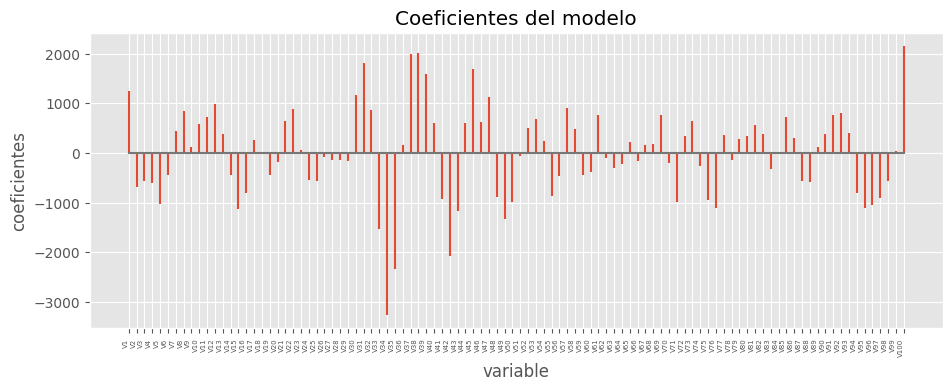

In [92]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo')
plt.show();

En comparación al modelo por mínimos cuadrados ordinarios, con ridge, el orden de magnitud de los coeficientes es mucho menor.

In [93]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([43.14618164, 40.39694011, 51.81659468,  9.99905589, 17.88495673,
        7.64777582, 28.17638049,  8.21462423, 14.71056192, 14.38270475])

In [94]:
# Error de test del modelo 
# ==============================================================================
rmse_ridge = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
             )
print("")
print(f"El error (rmse) de test es: {rmse_ridge}")


El error (rmse) de test es: 2.4486444979650397


Las predicciones del modelo final se alejan en promedio 2.45 unidades del valor real.

## Lasso

Cuando se utiliza regularización, es útil evaluar cómo se aproximan a cero los coeficientes a medida que se incrementa el valor de alpha así como la evolución del error de validación cruzada en función del alpha empleado

In [95]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto LassoCV utiliza el mean squared error
modelo = LassoCV(
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)

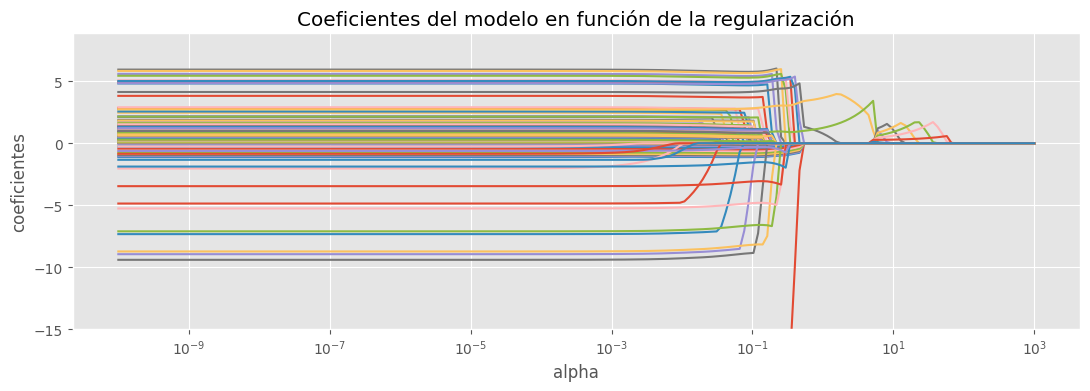

In [96]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(13, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show();

Puede ver se como, a medida que aumenta el valor de alpha, la regularización es mayor y más predictores quedan excluidos (su coeficiente es 0).

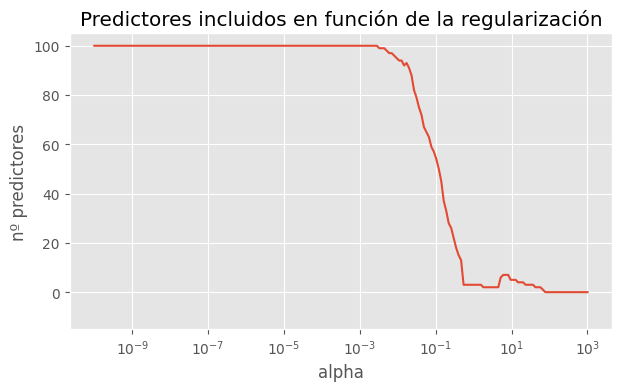

In [97]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha
# ==============================================================================
alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización')
plt.show();

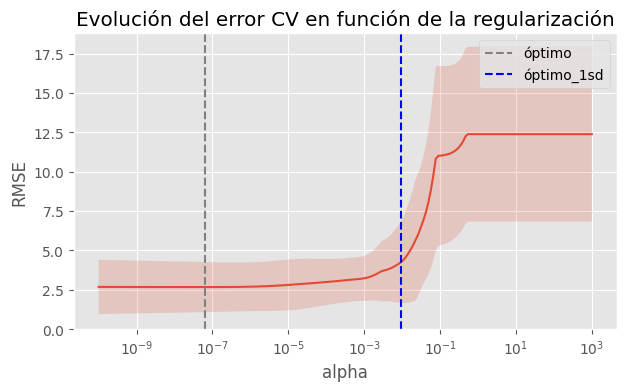

In [98]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_alphas, n_folds)
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(modelo.alphas_, rmse_cv + rmse_sd, rmse_cv - rmse_sd, alpha=0.2)

ax.axvline(x = optimo, c = "gray", linestyle = '--', label = 'óptimo')
ax.axvline(x = optimo_1sd, c = "blue", linestyle = '--', label = 'óptimo_1sd')

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()
plt.show();

In [99]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 6.44236350872137e-08


In [100]:
# Mejor valor alpha encontrado + 1sd
# ==============================================================================
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_1sd}")

Mejor valor de alpha encontrado + 1 desviación estándar: [0.0093293]


In [101]:
# Mejor modelo alpha óptimo + 1sd
# ==============================================================================
modelo = Lasso(alpha=optimo_1sd, normalize=True)
modelo.fit(X_train, y_train)

Lasso(alpha=array([0.0093293]), normalize=True)

In [102]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
6,V7,-2.689854
7,V8,-19.193858
8,V9,-17.208362
9,V10,-14.810154
10,V11,-12.830698
11,V12,-10.833377
12,V13,-8.808576
13,V14,-6.650346
14,V15,-4.576544
15,V16,-2.690044


De los 100 predictores disponibles, el modelo final solo incluye 24.

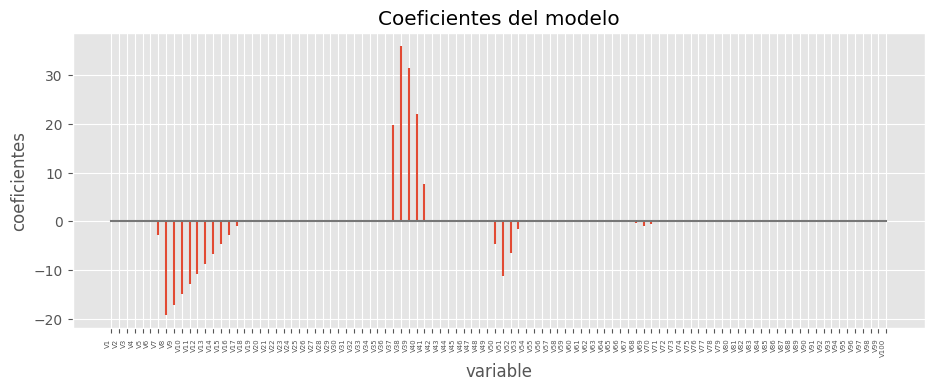

In [103]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo')
plt.show();

In [104]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([33.81085808, 52.74982381, 35.54150511, 12.16156541, 15.15281175,
        6.48349433, 24.29420923,  7.53635715, 13.70426716, 19.14206245])

In [105]:
# Error de test del modelo 
# ==============================================================================
rmse_lasso = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
             )
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 3.9543826426827415


Las predicciones del modelo final se alejan en promedio 3.95 unidades del valor real, utilizando solo 22 de los 100 predictores disponibles.

## Elastic net

In [106]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto ElasticNetCV utiliza el mean squared error
# Cuando l1_ratio = 0 , se aplica ridge y cuando l1_ratio = 1 se aplica lasso
modelo = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)

In [107]:
# Evolución del error en función de alpha y l1_ratio
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha y l1_ratio.
# Tiene dimensiones (n_l1_ratio, n_alpha, n_folds)

# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = modelo.mse_path_.mean(axis = 2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo.l1_ratio, modelo.alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo.alphas_,mse_cv,rmse_cv
977,0.90,2.736440e-09,7.149319,2.673821
976,0.90,3.180626e-09,7.149361,2.673829
978,0.90,2.354286e-09,7.149536,2.673862
1172,0.95,5.805226e-09,7.149672,2.673887
975,0.90,3.696913e-09,7.149697,2.673892
...,...,...,...,...
1209,0.99,2.582619e+02,153.287425,12.380930
1208,0.99,3.001836e+02,153.287425,12.380930
1207,0.99,3.489101e+02,153.287425,12.380930
1213,0.99,1.414991e+02,153.287425,12.380930


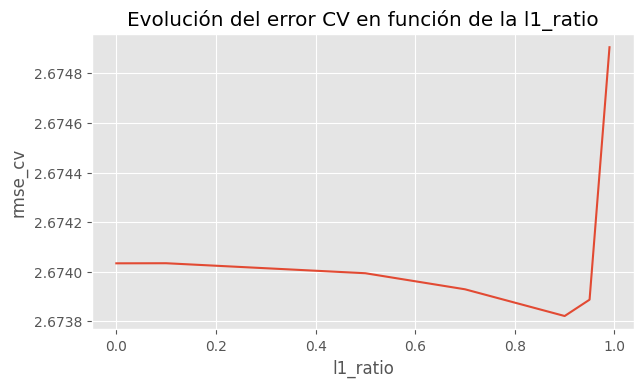

In [124]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv')
plt.show();

In [123]:
# Mejor valor alpha y l1_ratio_ encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo.l1_ratio_}")

Mejor valor de alpha encontrado: 2.7364399970746664e-09
Mejor valor de l1_ratio encontrado: 0.9


In [132]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

In [144]:
# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[(df_coeficientes.coef != 0)]

,predictor,coef
0,V1,137.647746
1,V2,-42.527364
2,V3,-40.455024
3,V4,-38.576775
4,V5,-36.493814
...,...,...
95,V96,1.141678
96,V97,-1.751019
97,V98,-5.541490
98,V99,-9.795299


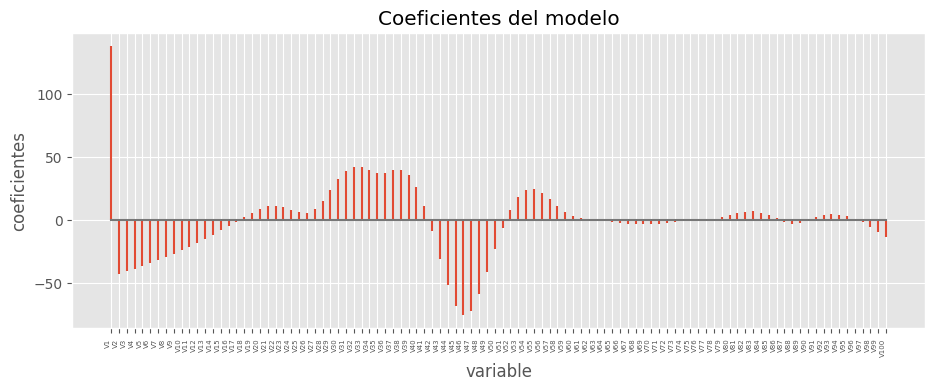

In [133]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo')
plt.show();

In [134]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()

In [135]:
# Error de test del modelo 
# ==============================================================================
rmse_elastic = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
               )
print("")
print(f"El error (rmse) de test es: {rmse_elastic}")


El error (rmse) de test es: 5.232941980868753


Las predicciones del modelo final se alejan en promedio 5.23 unidades del valor real, utilizando solo 22 de los 100 predictores disponibles.

# Comparación

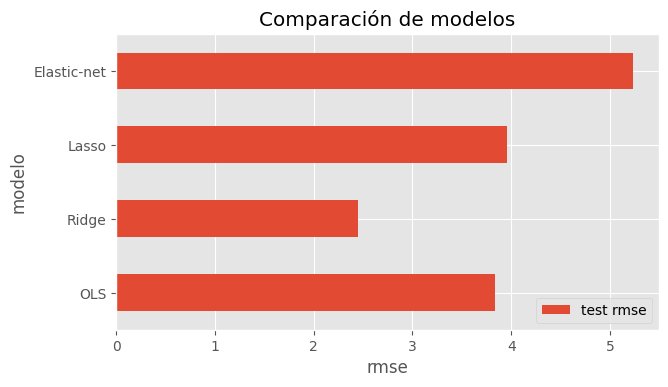

In [139]:
df_comparacion = pd.DataFrame({
                    'modelo': ['OLS', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos')
plt.show();

En este caso el mejor modelo se obtiene aplicando regularización **Ridge**. El modelo con regularización **Lasso** tiene un error ligeramente superior al modelo **OLS** pero emplea solo 24 predictores en lugar de 100. La regularización **Elastic-net** empeora el modelo.